In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

### The Big Problem

In *A – Species Inference from Movement Acoustics*, I discussed using hydrophones to classify deep-sea creatures from the acoustic signatures of their movements. Here, I want to pivot slightly to a closely related problem: how to find animal hotspots in the first place.

Much like the Earth’s surface, the ocean exhibits strong spatial variation in species abundance. Our goal is to identify regions rich in observable wildlife. The difficulty is that collecting observations is slow and expensive. Measuring species density requires deploying equipment, descending to depth, capturing sufficient video, analyzing it, and then relocating to another site.

This is fundamentally a scarce-data problem. Each data point is costly, so we need methods that make sampling as efficient as possible. Fortunately, machine learning offers tools designed specifically for sample-efficient exploration.

### The Solution: Gaussian Processes

Gaussian Processes (GPs) are particularly well suited to this task because they provide not only predictions, but also uncertainty estimates at unobserved locations. This allows us to compute the *expected improvement* of sampling at a new site and choose the location that maximizes this quantity.

A Gaussian Process models the values of a function at different locations as a multivariate normal distribution. Suppose we consider $n$ locations, some observed and some unobserved. The function values at these locations are assumed to follow an $n$-dimensional Gaussian distribution. Predictions are made by conditioning the unobserved values on the observed ones.

The spatial structure enters through the covariance matrix, which is constructed from the input locations $X$. Typically, covariance is defined as a decreasing function of distance: points that are close together have high covariance, while distant points have low covariance.

### A Simple Example

Consider the simplest possible case: two locations, one observed (training) point and one unobserved (test) point.

Suppose we define the covariance between any two points as

$$
k(d) = \exp(-12 d^2)
$$

where $d$ is the distance between them. This function looks something like this:

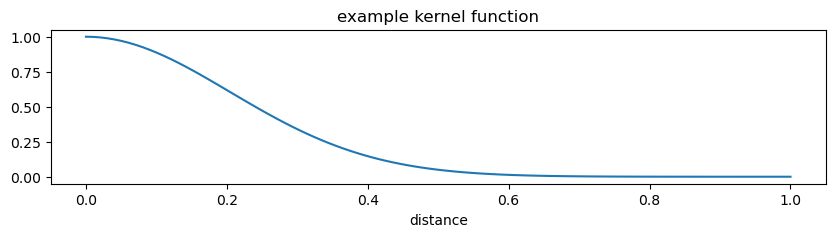

In [2]:
distances = np.linspace(0,1,100)
kernel = np.exp(-12*distances**2)
plt.figure(figsize=(10,2))
plt.plot(distances, kernel)
plt.title("example kernel function")
plt.xlabel("distance")
plt.show()

If the distance between the training point and the test point is $d = 0.2$, this kernel yields a covariance of approximately $0.618$.

If we go back to our 2 points case the joint covariance matrix for the two function values is then

$$
\begin{pmatrix}
1 & 0.618 \\
0.618 & 1
\end{pmatrix}
$$

Once we have this covariance we can conditioning on the observed value at the training point to infer both the expected value and the uncertainty at the test point. See the below.

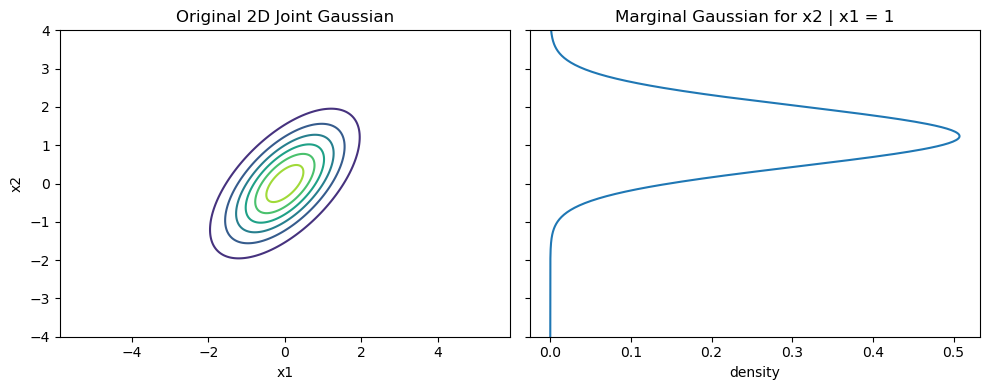

In [3]:
mean = np.array([0.0, 0.0])
cov = np.array([
    [1.0, 0.618],
    [0.618, 1.0]
])

# This says we believe there is a 0.3 correlation between the two
# Imagine we then see that the first value is 2. 
# Then we condition with that value to get a new gaussian over the values for the second.

def condition_gaussian(mean, cov, known_indicies, known_values):
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    known_indicies = np.asarray(known_indicies)
    known_values = np.asarray(known_values)

    all_indicies = np.arange(len(mean))
    unknown_indicies = np.setdiff1d(all_indicies, known_indicies)

    mu_k = mean[known_indicies]
    mu_u = mean[unknown_indicies]

    Sigma_kk = cov[np.ix_(known_indicies, known_indicies)]
    Sigma_ku = cov[np.ix_(known_indicies, unknown_indicies)]
    Sigma_uk = cov[np.ix_(unknown_indicies, known_indicies)]
    Sigma_uu = cov[np.ix_(unknown_indicies, unknown_indicies)]

    Sigma_kk_inv = np.linalg.inv(Sigma_kk)

    cond_mean = mu_u + Sigma_uk @ Sigma_kk_inv @ (known_values - mu_k)
    cond_cov = Sigma_uu - Sigma_uk @ Sigma_kk_inv @ Sigma_ku

    return cond_mean, cond_cov


# Plotting

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 4),
    sharey=True
)

# ----- LEFT: Original 2D Joint Gaussian -----

rv = multivariate_normal(mean=mean, cov=cov)

x = np.linspace(-4, 4, 200)
y = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

Z = rv.pdf(pos)

axes[0].contour(X, Y, Z)
axes[0].set_xlabel("x1")
axes[0].set_ylabel("x2")
axes[0].set_title("Original 2D Joint Gaussian")
axes[0].axis("equal")

# ----- RIGHT: Marginal on the second variable -----

cond_mean, cond_cov = condition_gaussian(
    mean,
    cov,
    known_indicies=[0],
    known_values=[2.0]
)

rv_cond = norm(loc=cond_mean[0], scale=np.sqrt(cond_cov[0, 0]))

x2 = np.linspace(-4, 4, 400)
pdf_x2 = rv_cond.pdf(x2)

axes[1].plot(pdf_x2, x2)
axes[1].set_xlabel("density")
axes[1].set_title("Marginal Gaussian for x2 | x1 = 1")

plt.tight_layout()
plt.show()

Here on the left we see the prior over the value at both points. This was generated by using the distance between the points to get the covariance. Then on the right we see what the distribution over the value of the second point looks like after conditioning on the true value of the first. 

Importantly both points could be images, they could be coordinates, they could be anything. All we do is specify that their outputs are jointly distributed in a multivariate gaussian.

### Application to the scarce-data problem

Because this method generates realistic error bars on it's predictions we can determine the expected improvement of sampling at a new location. Expected improvement is how much better we expect our highest sample to be, after trying the new sample. If we maximise this quantity we are doing smart inference about where to sample next.

Let's go back to our ocean setting an imagine we have some distribution over observation frequency on the sea floor (1 dimensional for now):

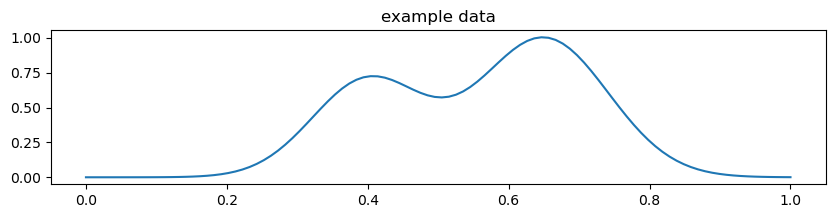

In [4]:
x = np.linspace(0,1,100)
y = 0.7 * np.exp(-80*(x-0.4)**2) + np.exp(-60*(x-0.65)**2)
plt.figure(figsize=(10,2))
plt.plot(x,y)
plt.title("example data")
plt.show()

Here the y axis refers to the number of fish / creatures swimming at each point. 

Now let's try out the gaussian process idea. Here we'll take 1 sample at a time, update our beliefs about the values of the other points (using the covariance as determined by distance), and then sample next at the point where there is the greatest expected improvement.

sampling at 0.0


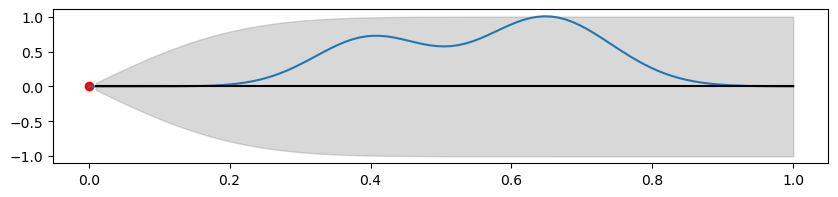

sampling at 1.0


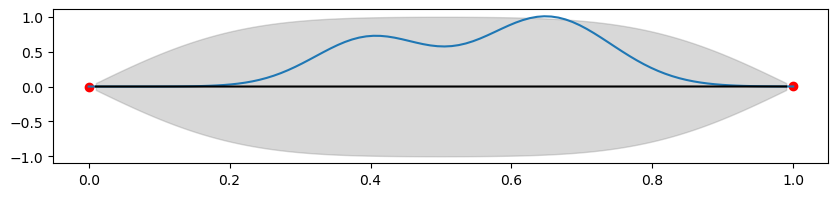

sampling at 0.51


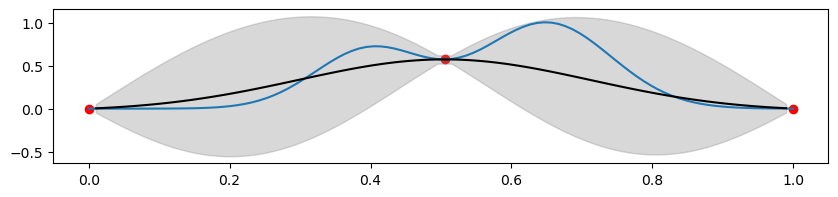

sampling at 0.49


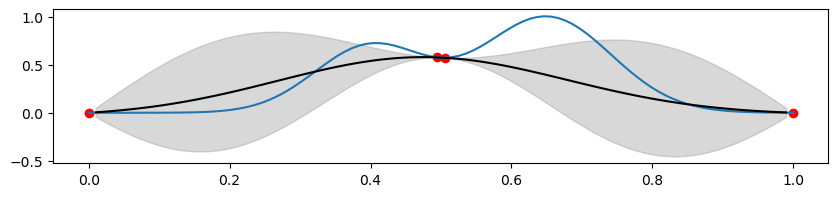

sampling at 0.47


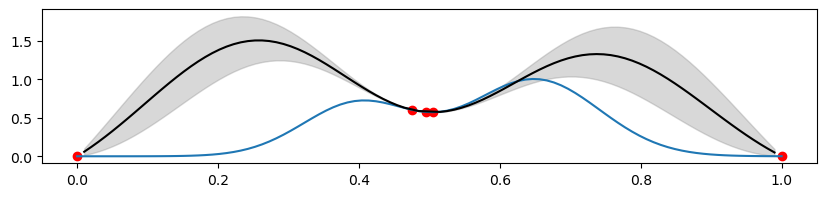

sampling at 0.26


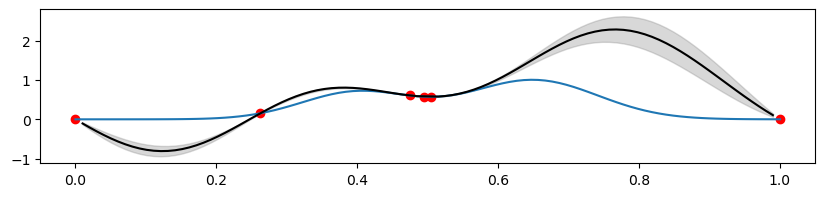

sampling at 0.77


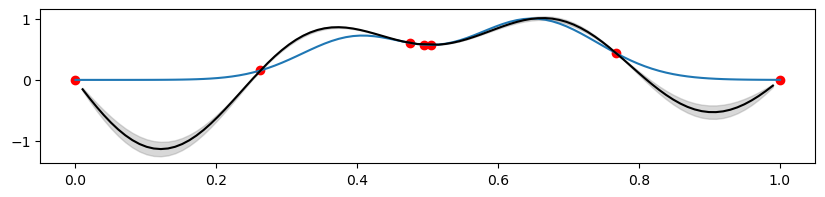

sampling at 0.67


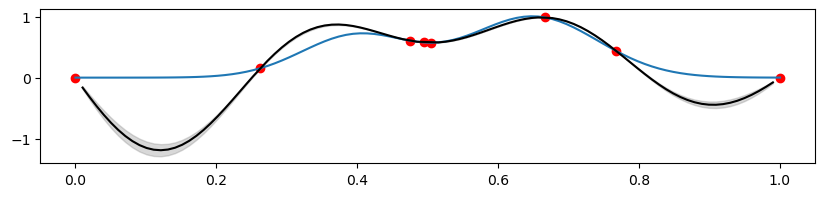

In [5]:
# Start off with an arbitrary mean for each sample
mean = np.zeros(len(x))

cov = np.exp(-12 * (x.reshape(-1,1) - x.reshape(1,-1))**2)
cov += 1e-8 * np.eye(len(x))
std = np.sqrt(np.diag(cov)) # just the std for each individual point, used for maximum expected improvement

current_peak = 0

x_copy = x.copy()
y_copy = y.copy()
x_samples = []
y_samples = []

# Now let's do a loop over the samples we take
for step in range(8):
    expected_improvements = []
    for i in range(len(mean)): # for any point we don't know we find it's expected value given the current gaussian
        Z = (mean[i] - current_peak) / std[i]
        expected_improvement = (mean[i] - current_peak) * norm.cdf(Z) + std[i] * norm.pdf(Z)
        expected_improvements.append(expected_improvement)

    # Choose the point with the greatest expected improvement to sample
    where_to_sample = np.argmax(expected_improvements)
    print("sampling at", round(x_copy[where_to_sample],2))
    mean, cov = condition_gaussian(mean, cov, [where_to_sample], y_copy[where_to_sample])
    std = np.sqrt(np.diag(cov))

    x_samples.append(x_copy[where_to_sample])
    y_samples.append(y_copy[where_to_sample])
    x_copy = np.delete(x_copy, where_to_sample)
    y_copy = np.delete(y_copy, where_to_sample)
    
    # Plot. The grey curve here represennts the uncertainty, red points are the samples.
    plt.figure(figsize=(10,2))
    plt.plot(x, y, label="True function")
    plt.scatter(x_samples, y_samples, color="red", label="Samples")
    plt.fill_between(x_copy, mean-std, mean+std, color='gray', alpha=0.3, label="GP uncertainty")
    plt.plot(x_copy, mean, color="black", label="GP mean")
    plt.show()

There we go! Notice that when the algorithm starts to know a particular spot it will automatically go to wherever it hasn't covered yet. This is different behaviour to something like gradient descent, which will just take local steps upwards. It finds fairly quickly the maximum point and uses few samples to do it. While this method will struggle to train a neural network, due to the high dimensionality, navigating a 2d or 3d function is perfectly doable.

2d example:

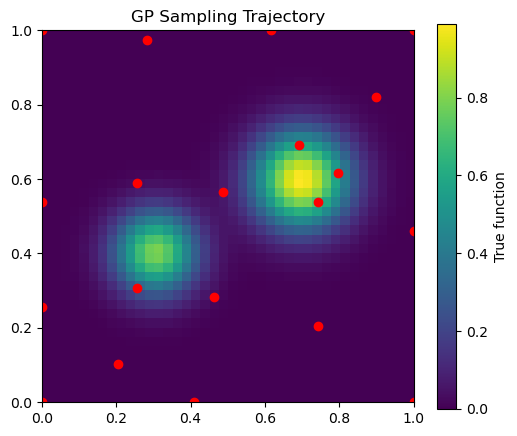

In [6]:
# --- 2D grid ---
n = 40
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
X1, X2 = np.meshgrid(x1, x2)

# True 2D function
Y = (
    0.8 * np.exp(-80*((X1-0.3)**2 + (X2-0.4)**2)) +
    1.0 * np.exp(-60*((X1-0.7)**2 + (X2-0.6)**2))
)

# Flatten for GP bookkeeping
X = np.column_stack([X1.ravel(), X2.ravel()])
y_true = Y.ravel()

# --- RBF kernel in 2D ---
def rbf_kernel_2d(Xa, Xb, lengthscale=0.2):
    sqdist = (
        np.sum(Xa**2, axis=1)[:, None]
        + np.sum(Xb**2, axis=1)[None, :]
        - 2 * Xa @ Xb.T
    )
    return np.exp(-sqdist / (2 * lengthscale**2))

# --- GP conditioning helper ---
def condition_gaussian(mean, cov, idx, value):
    idx = idx[0]
    k = cov[:, idx]
    c = cov[idx, idx]
    mean_new = mean + k * (value - mean[idx]) / c
    cov_new = cov - np.outer(k, k) / c
    return mean_new, cov_new

# --- Initialize GP ---
mean = np.zeros(len(X))
cov = rbf_kernel_2d(X, X) + 1e-8 * np.eye(len(X))
std = np.sqrt(np.diag(cov))

current_peak = -np.inf

X_copy = X.copy()
y_copy = y_true.copy()
X_samples = []
y_samples = []

# --- Bayesian optimization loop ---
for step in range(20):
    expected_improvements = []

    for i in range(len(mean)):
        Z = (mean[i] - current_peak) / std[i]
        EI = (mean[i] - current_peak) * norm.cdf(Z) + std[i] * norm.pdf(Z)
        expected_improvements.append(EI)

    # Pick next point
    where = np.argmax(expected_improvements)
    y_obs = y_copy[where]
    mean, cov = condition_gaussian(mean, cov, [where], y_obs)

    # Store sample
    X_samples.append(X_copy[where])
    y_samples.append(y_obs)
    current_peak = max(current_peak, y_obs)

    # Remove sampled point
    X_copy = np.delete(X_copy, where, axis=0)
    y_copy = np.delete(y_copy, where)
    mean = np.delete(mean, where)
    cov = np.delete(np.delete(cov, where, axis=0), where, axis=1)
    std = np.sqrt(np.diag(cov))

# --- Final plot with trajectory ---
plt.figure(figsize=(6,5))
plt.imshow(
    Y,
    extent=(0,1,0,1),
    origin="lower",
    cmap="viridis"
)
plt.colorbar(label="True function")

xs = np.array(X_samples)
plt.scatter(xs[:,0], xs[:,1], color="red") 

plt.title("GP Sampling Trajectory")
plt.show()

So the model here manages to place 3 samples near the peak point after just 20 steps.

### But what about travel disatance?

Notice that in the above cases the next sample is taken regardless of how far away it might be from the one before. But what if the cost of these samples grows with distance? Imagine an autonomous vehicle that needs to travel to wherever the next sample is. What do we do then? Fortunately the gaussian process method can be improved to also account for this. I'll write up about that in the next notebook.